In [24]:
import time

import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage.morphology import medial_axis


from RANSAC import get_codirectional_lines, get_best_dist
# from ImgCropper import ImgCropper

In [25]:
image = cv2.imread('images/obl1.jpg')
image.shape

(800, 800, 3)

(800, 800)


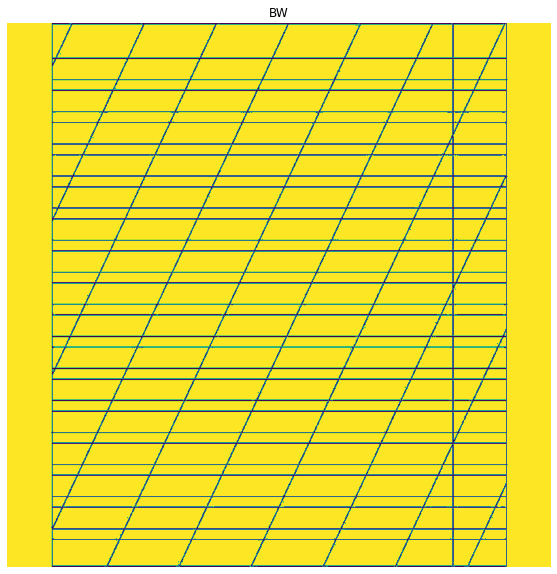

In [26]:
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

## do morph-dilate-op
kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (10,10))
dilated = cv2.morphologyEx(gray, cv2.MORPH_DILATE, kernel)
median = cv2.medianBlur(dilated, 5)
diff2 = 255 - cv2.subtract(median, gray)
normed = cv2.normalize(diff2,None, 10, 255, cv2.NORM_MINMAX )

bw = cv2.threshold(normed, 220, 255, cv2.THRESH_BINARY)[1]
plt.figure(figsize=(10,10))
plt.clf()
plt.axis("off")
plt.title("BW")
plt.imshow(bw)

edges = cv2.Canny(bw, 200, 120, apertureSize=3, L2gradient=True)
print(edges.shape)

In [49]:
lines = cv2.HoughLines(edges, 1, np.pi/360, 300,)
lines_points = np.empty((len(lines), 4), dtype=int)
lines_coefs = np.empty((len(lines), 3))

for i, line in enumerate(lines):
    for rho, theta in line:
        a = np.cos(theta)
        b = np.sin(theta)
        x0 = a*rho
        y0 = b*rho
        x1 = int(x0 + 1648*(-b))
        y1 = int(y0 + 1648*(a))
        x2 = int(x0 - 1648*(-b))
        y2 = int(y0 - 1648*(a))
        lines_points[i] = (x1, y1, x2, y2)
        lines_coefs[i] = np.cross((x1, y1, 1), (x2, y2, 1))

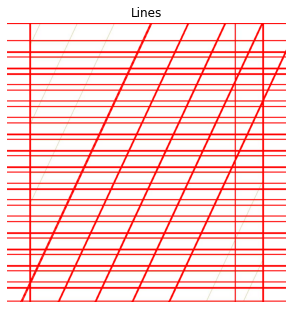

In [50]:
img_copy = image.copy()
for i, (x1, y1, x2, y2) in enumerate(lines_points):
    cv2.line(img_copy, (x1, y1), (x2, y2), (255,0,0),2)
#     else:
#         cv2.line(img_copy, (x1, y1), (x2, y2), (0,255, 0),2)
    
plt.figure(figsize=(5,10))
plt.clf()
plt.axis("off")
plt.title("Lines")
plt.imshow(img_copy)  

In [51]:
%%time
print(f"found lines: {len(lines_coefs)}")  
line_group1, mask, v_point1 = get_codirectional_lines(lines_coefs, iters=2000, epsilon=0.0005)
print(f"lines in group 1: {len(line_group1)}")
v_point1

found lines: 59
lines in group 1: 43
CPU times: user 3.86 s, sys: 187 ms, total: 4.05 s
Wall time: 8.74 s


array([3.66967445e+09, 1.11371000e+06, 0.00000000e+00])

In [52]:
lines_points1 = lines_points[mask]
lines_points = lines_points[~mask]
lines_coefs=lines_coefs[~mask]
line_group2, mask, v_point2 = get_codirectional_lines(lines_coefs, iters=2000, epsilon=0.0005)
print(f"lines in group 2: {len(line_group2)}")
v_point2

lines in group 2: 9


array([-14407200.,  30905100.,         0.])

In [53]:
lines_points2 = lines_points[mask]
lines_points = lines_points[~mask]
lines_coefs=lines_coefs[~mask]
line_group3, mask, v_point3= get_codirectional_lines(lines_coefs, iters=2000, epsilon=0.0005)
print(f"lines in group 2: {len(line_group3)}")
v_point3

lines in group 2: 4


array([ 0.00000000e+00, -7.27862272e+09,  0.00000000e+00])

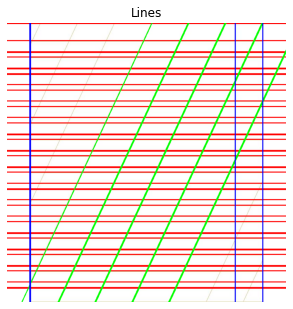

In [55]:
img_copy = image.copy()
lines_points3 = lines_points[mask]
if v_point1[2] != 0:
    v_point1 = v_point1/v_point1[2]
    
for i, (x1, y1, x2, y2) in enumerate(lines_points1):
    if abs(v_point1[0]/v_point1[1]) > 1:
        cv2.line(img_copy, (x1, y1), (x2, y2), (255,0,0),2)
    else:
        cv2.line(img_copy, (x1, y1), (x2, y2), (0,255, 0),2)
for i, (x1, y1, x2, y2) in enumerate(lines_points2):
    if abs(v_point2[0]/v_point2[1]) < 1:
        cv2.line(img_copy, (x1, y1), (x2, y2), (0,255,0),2)
    else:
        cv2.line(img_copy, (x1, y1), (x2, y2), (255,0, 0),2)
for i, (x1, y1, x2, y2) in enumerate(lines_points3):
    if abs(v_point3[0]/v_point3[1]) < 1:
        cv2.line(img_copy, (x1, y1), (x2, y2), (0,0, 255),2)
    else:
        cv2.line(img_copy, (x1, y1), (x2, y2), (255,0, 0),2)

plt.figure(figsize=(5,10))
plt.clf()
plt.axis("off")
plt.title("Lines")
plt.imshow(img_copy)  

In [47]:
def _find_corner_points(lines1, vp1, lines2):
        if vp1[2] != 0:
            vp1 = vp1/vp1[2]
        if abs(vp1[0]/vp1[1]) < 1:
            vertical = lines1
            horizontal = lines2
        else:
            vertical = lines2
            horizontal = lines1
        l1 = horizontal[(-horizontal[:, 2]/horizontal[:, 1]).argmin()] #y-intercept - top
        l2 = vertical[(-vertical[:, 2]/vertical[:, 0]).argmin()] #x-intercept - left
        l3 = horizontal[(-horizontal[:, 2]/horizontal[:, 1]).argmax()] #x-intercept - bottom
        l4 = vertical[(-vertical[:, 2]/vertical[:, 0]).argmax()] #y-intercept - right
        corner_points = np.cross([l1, l2, l3, l4], [l2, l3, l4, l1])
        sheet_corners = (corner_points / corner_points[:, 2][:, None])[:, :2]
        return sheet_corners

In [56]:
corners = _find_corner_points(line_group1, v_point1, line_group3)
corners

array([[6.50000000e+01, 5.19878604e-01],
       [6.50000000e+01, 7.59519879e+02],
       [7.33000000e+02, 7.59722610e+02],
       [7.33000000e+02, 7.22610015e-01]])

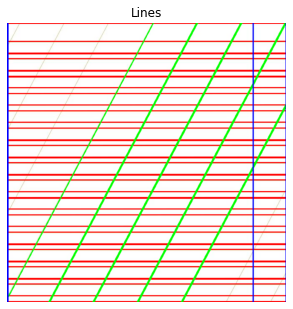

In [57]:
cropped_shape = img_copy.shape[1], img_copy.shape[0]
srcpts = np.float32([corners])
destpts = np.float32([[0, 0], [0, cropped_shape[1]], cropped_shape, [cropped_shape[0], 0]])
resmatrix = cv2.getPerspectiveTransform(srcpts, destpts)
img_copy_new = cv2.warpPerspective(img_copy, resmatrix, cropped_shape) 
plt.figure(figsize=(5,10))
plt.clf()
plt.axis("off")
plt.title("Lines")
plt.imshow(img_copy_new)